Let's first load the necessary packages and libraries

In [1]:
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt

from Graph_Generation.simple_graph_generation import create_occupancy_grid
from Graph_Generation.target_graph import create_fully_connected_target_graph
from Graph_Generation.visibility import hill_visibility
from Graph_Generation.edge_block_generation import block_specific_edges
from Single_Agent.repeated_topk import RepeatedTopK
from Single_Agent.VOI import VOITrajectoryManager
from Single_Agent.RPP import ZeroCostRPP

Let's generate the graph (a $n$ corridor graph)


At the moment we have the following graph features


Node Level: 

- "type": "source", "target_unreached", "target_reached", "intermediate" 

- "visible_edges": a map from each node to the visible edges 

- 'pos' : a 2D tuple of the nodes' position


Edge Level: 

- "distance": Euclidian distance of the edge 

- "observed_edge" : boolean of whether or not the edge was observed 
    
- "num_used" : an edge value function 

- "blocked" : a boolean denoting the blockage of an edge

In [2]:
# We will remove three blobs
blob1 = [(1,12), (2,12), (2,11), (3,11), (3,10), (4,10)]
blob2 = [(6,8), (7,7), (6,9), (7,8), (8,7), (8,8), (7,9), (9,6)]
blob3 = [(7,1), (7,2), (8,1), (8,2), (8,3), (8,4), (9,2), (9,3), (9,4)]
blob4 = [(7,12), (8,12), (7,13), (8,13)]
blob5 = [(4,0), (5,0)]
sef_of_blobs = blob1 + blob2 + blob3 + blob4 + blob5

# We also define the hill nodes
hill_nodes = [(2,2), (2,3), (3,2), (3,3)]


env_graph = create_occupancy_grid(m=14, n=14, nodes_to_remove=sef_of_blobs)
env_graph = hill_visibility(env_graph, hill_nodes)
target_graph = create_fully_connected_target_graph(env_graph)

Let's first visualize the environment graph

C:\Users\jongs\AppData\Local\Temp\ipykernel_1912\1511380275.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


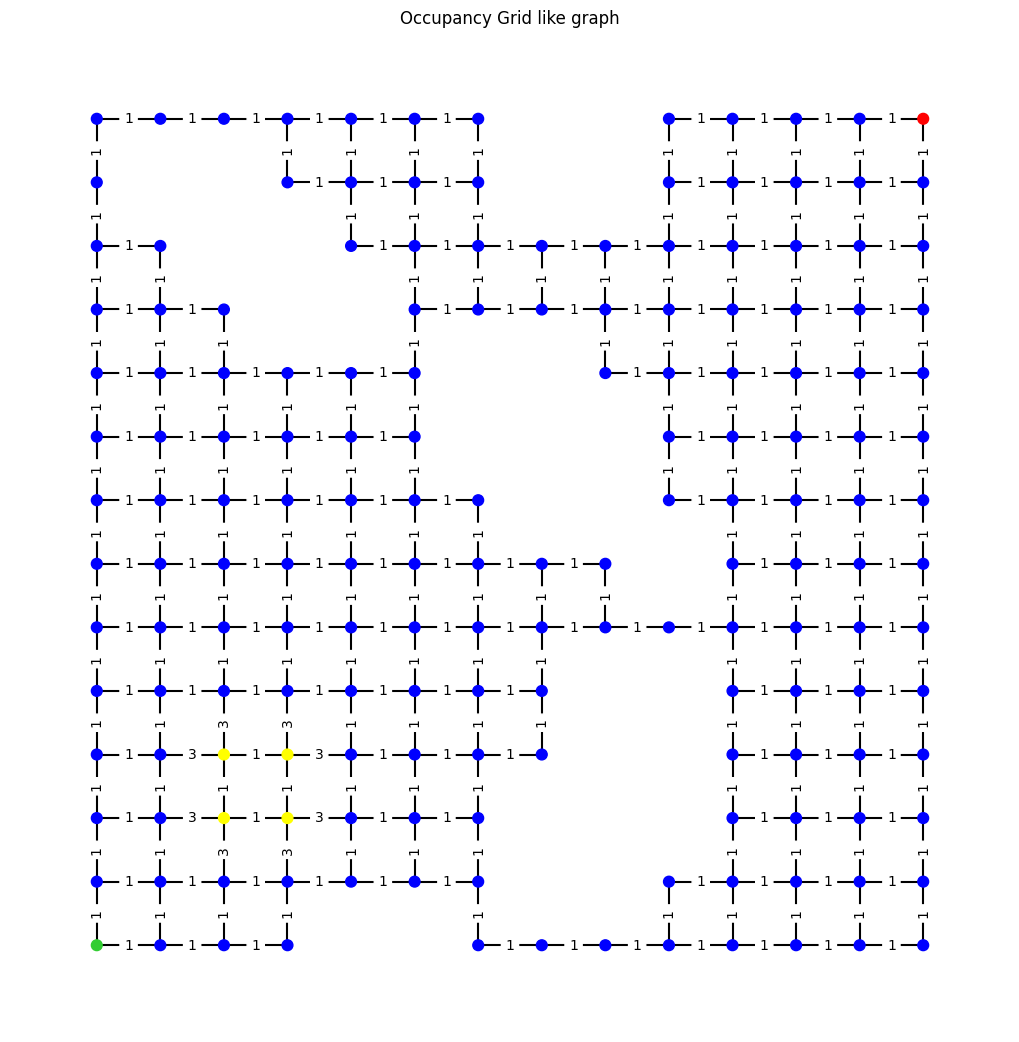

In [3]:
extended_nodes = [node for node in hill_nodes if node in env_graph]
non_extended_nodes = [node for node in env_graph.nodes() if node not in hill_nodes]

# source_node = extended_nodes[0] if extended_nodes else non_extended_nodes[0]
# visible_edges = env_graph.nodes[source_node]['visible_edges']

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

# Draw the graph with updated styles
plt.figure(figsize=(10, 10))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color='black'
)

# Add Edge Labels (Distance)
edge_labels = nx.get_edge_attributes(env_graph, 'distance')

# Format floats to 2 decimal places for cleaner visualization
formatted_labels = {k: f"{v:.0f}" for k, v in edge_labels.items()}

nx.draw_networkx_edge_labels(
    env_graph,
    pos,
    edge_labels=formatted_labels,
    font_size=10,
    label_pos=0.5
)

plt.title("Occupancy Grid like graph")
plt.axis('off') # Turn off axis for cleaner look
plt.tight_layout()
plt.show()

Let's also visulize the target graph and the 'num_used' weights

The target graph is a simpler graph made of only the target nodes. The edges are generated by connecting the 4 closest neighbors.

The target graph feature are

Node Level: 

- "type": "source", "target_unreached", "target_reached", "intermediate" 

- 'pos' : a 2D tuple of the nodes' position


Edge Level: 

- 'distance': Shortest Path length between the two target nodes

- 'diverse_paths' : A list containing 3 of the shortest diverse paths between the two targets 

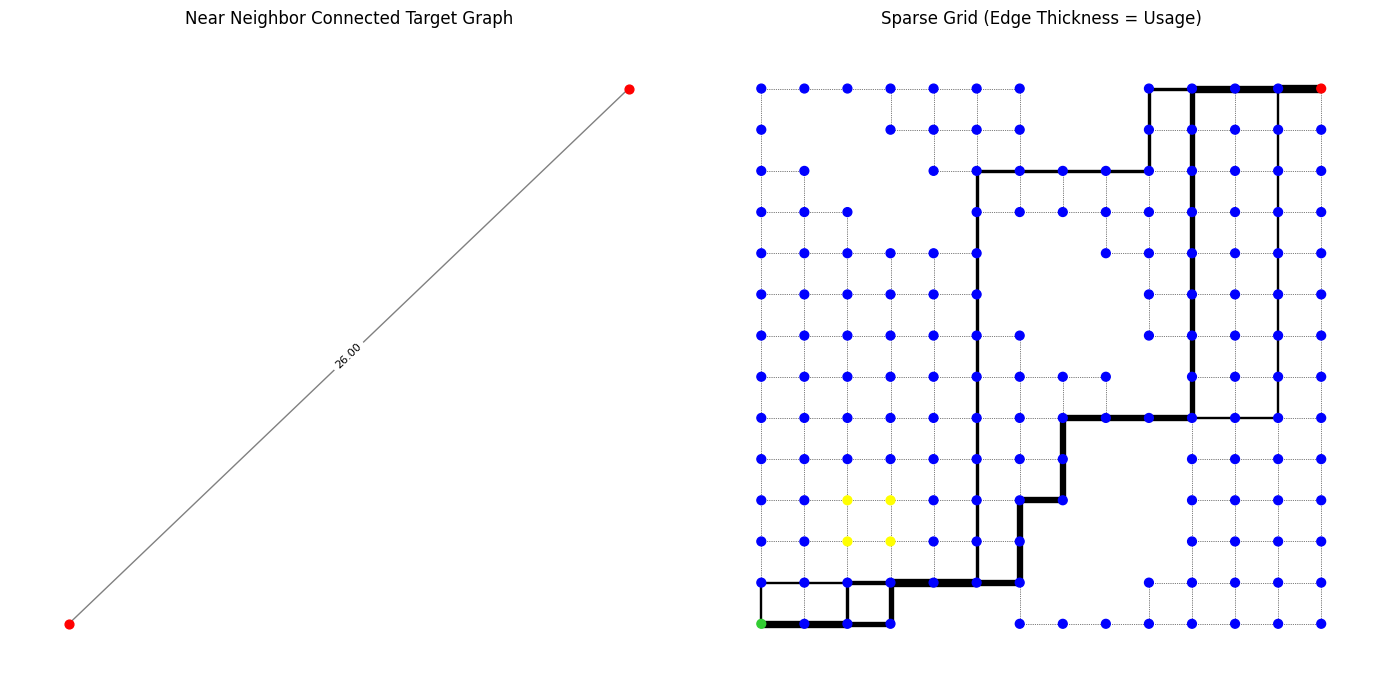

In [4]:
# --- 1. Prepare for Plotting ---

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")   
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_labels = {}
for u, v, data in target_graph.edges(data=True):
    distance = data['distance']
    edge_labels[(u, v)] = f"{distance:.2f}"

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in env_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 5.0 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.5)

# --- 3. Create the Side-by-Side Plot (in the new order) ---

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# --- Plot 1: Fully Connected Target Graph (NOW on the left axis) ---
axes[0].set_title("Near Neighbor Connected Target Graph")
nx.draw(
    target_graph,
    pos=pos,
    ax=axes[0],  # Draw on the left subplot
    node_color="red",
    with_labels=False,
    node_size=40,
    width=1.0,
    edge_color='grey'
)

nx.draw_networkx_edge_labels(
    target_graph, 
    pos=pos,
    ax =axes[0],
    edge_labels=edge_labels,
    font_size=8
)

# --- Plot 2: Original Sparse Grid with Usage (NOW on the right axis) ---
axes[1].set_title("Sparse Grid (Edge Thickness = Usage)")
nx.draw(
    env_graph,
    pos=pos,
    ax=axes[1],  # Draw on the right subplot
    node_color=color_map,
    with_labels=False,
    node_size=40,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Before we created the blocked edge environment, let's instantiate the path generator. This will be used to figure out the shortest path based on distance. (We will be blocking edges on this path)

In [5]:
path_generator = RepeatedTopK(reward_ratio = 1.0, env_graph=env_graph, target_graph=target_graph)

shortest_path = []
hamiltonian_target_path = path_generator.generate_Hamiltonian_path()
for i in range(len(hamiltonian_target_path) - 1):
    begin_node = hamiltonian_target_path[i]
    end_node = hamiltonian_target_path[i + 1]

    section_path = nx.shortest_path(env_graph, source=begin_node, target=end_node, weight="distance")

    # Append the section best path, avoiding duplication of nodes at the end
    if len(shortest_path) > 0 and shortest_path[-1] == section_path[0]:
        shortest_path.extend(section_path[1:])
    else:
        shortest_path.extend(section_path)


# If we want to make list of edges to block instead
edges_to_block = [
    ((8,5), (9,5)),
    ((5,9), (5,10))
]

TSP Cycle: [(0, 0), (13, 13)]


Let's now block some of the edges on the graph. 

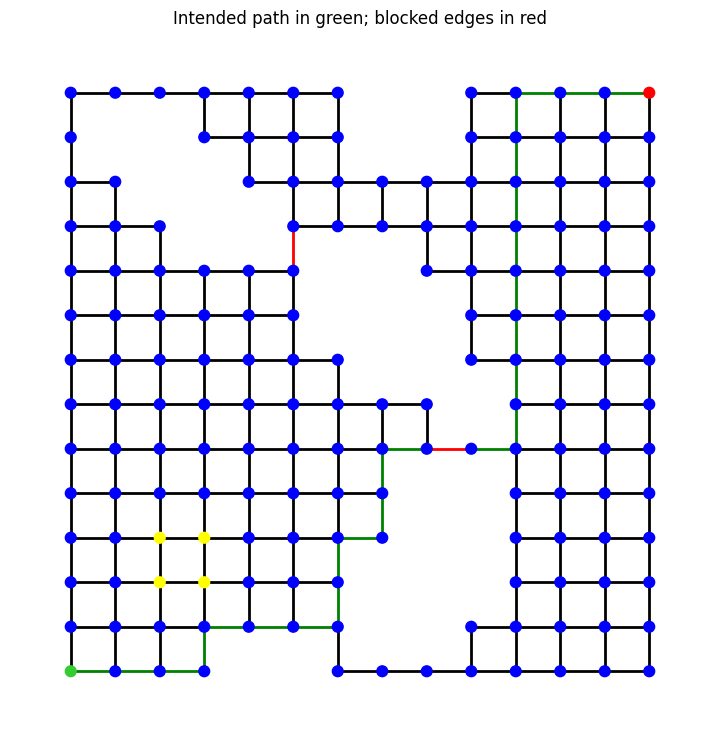

In [6]:
# This will serve as the real environment (env_graph now a ideal map for planning purposes)
blocked_env_graph = block_specific_edges(env_graph, edges_to_block=edges_to_block)


blocked_edges = [edge for edge in blocked_env_graph.edges()
                 if blocked_env_graph.edges[edge].get('blocked', True)]

shortest_path_edges = {tuple(sorted((shortest_path[i], shortest_path[i+1]))) 
                   for i in range(len(shortest_path) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in blocked_edges:
        # Style for blocked edges: orange
        edge_color.append('red')
    elif edge_tuple in shortest_path_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=2.0,
    edge_color=edge_color
)

plt.title("Intended path in green; blocked edges in red")
plt.show()

Let's first get an innocent shortest path agent to navigate this environment

In [7]:
# Remove all blocked edges from the blocked_env_graph
edges_to_remove = [(u, v) for u, v, data in blocked_env_graph.edges(data=True) if data.get('blocked', False)]
blocked_env_graph.remove_edges_from(edges_to_remove)

# Update the visible_edges for all nodes to reflect the removed edges
for node in blocked_env_graph.nodes():
    if "visible_edges" in blocked_env_graph.nodes[node]:
        current_visible = blocked_env_graph.nodes[node]["visible_edges"]
        # Remove any blocked edges from the visible_edges set
        updated_visible = set(current_visible) - set(edges_to_remove)
        blocked_env_graph.nodes[node]["visible_edges"] = list(updated_visible)

In [8]:
# This is for the agent operating on shortest path

path_1 = shortest_path.copy() # Start with the shortest path
target_nodes = hamiltonian_target_path.copy()  # All target nodes
env_graph1 = env_graph.copy() # Agent's world model (doesn't know any edges are blocked)

current_node = path_1[0]
next_target_index = 1 # since 0 is the source
index = 0

while index < len(path_1) - 1:
    next_node = path_1[index + 1]

    # Update the next_target_index 
    if current_node == target_nodes[next_target_index]:
        next_target_index += 1
    
    # Check out all the observable edges
    observable_edges = set(blocked_env_graph.nodes[current_node]["visible_edges"]) # From the actual blocked env graph
    assumed_observable_edges = set(env_graph1.nodes[current_node]["visible_edges"]) # From the agent's world model 
    blocked_edges = assumed_observable_edges - observable_edges
    
    if len(blocked_edges) > 0:
        # Remove blocked edges from agent's world model
        for edge in blocked_edges:
            u, v = edge
            if env_graph1.has_edge(u, v):
                print(f"From {current_node}, observed edge ({u}, {v}) is blocked. Removing from graph.")
                env_graph1.remove_edge(u, v)
                # Update the visibility mapping as well
                for node in env_graph1.nodes():
                    if "visible_edges" in env_graph1.nodes[node]:
                        current_visible = env_graph1.nodes[node]["visible_edges"]
                        # Remove any blocked edges from the visible_edges set
                        updated_visible = set(current_visible) - blocked_edges
                        env_graph1.nodes[node]["visible_edges"] = list(updated_visible)
        
        # Check if any blocked edge is in our current path
        path_edges = [(path_1[i], path_1[i+1]) for i in range(index, len(path_1) - 1)]

        # Create a set that includes both directions of blocked edges
        blocked_edges_both_directions = set()
        for u, v in blocked_edges:
            blocked_edges_both_directions.add((u, v))
            blocked_edges_both_directions.add((v, u))
        
        if any(edge in blocked_edges_both_directions for edge in path_edges):
            print(f"Blocked edge detected in planned path. Recalculating entire remaining path...")
            
            # Replan through ALL remaining targets
            remaining_targets = target_nodes[next_target_index:]
            new_path = [current_node]
            
            for target in remaining_targets:
                segment = nx.shortest_path(env_graph1, source=new_path[-1], target=target, weight="distance")
                new_path.extend(segment[1:])  # Append segment excluding the first node (already in new_path)
            
            # Replace the rest of path_1 with the new path
            path_1 = path_1[:index + 1] + new_path[1:]

    # Get the next node from the (possibly updated) path
    next_node = path_1[index + 1]
    
    # Now that we have a traversable path, just go to the next node in path
    print(f"Moving from {current_node} to {next_node}")
    current_node = next_node
    index += 1


Moving from (0, 0) to (1, 0)
Moving from (1, 0) to (2, 0)
Moving from (2, 0) to (3, 0)
Moving from (3, 0) to (3, 1)
Moving from (3, 1) to (4, 1)
Moving from (4, 1) to (5, 1)
Moving from (5, 1) to (6, 1)
Moving from (6, 1) to (6, 2)
Moving from (6, 2) to (6, 3)
Moving from (6, 3) to (7, 3)
Moving from (7, 3) to (7, 4)
Moving from (7, 4) to (7, 5)
Moving from (7, 5) to (8, 5)
From (8, 5), observed edge ((8, 5), (9, 5)) is blocked. Removing from graph.
Blocked edge detected in planned path. Recalculating entire remaining path...
Moving from (8, 5) to (7, 5)
Moving from (7, 5) to (6, 5)
Moving from (6, 5) to (5, 5)
Moving from (5, 5) to (5, 6)
Moving from (5, 6) to (5, 7)
Moving from (5, 7) to (5, 8)
Moving from (5, 8) to (5, 9)
From (5, 9), observed edge ((5, 9), (5, 10)) is blocked. Removing from graph.
Blocked edge detected in planned path. Recalculating entire remaining path...
Moving from (5, 9) to (4, 9)
Moving from (4, 9) to (3, 9)
Moving from (3, 9) to (2, 9)
Moving from (2, 9) to 

Let's now see the innocent agent's path

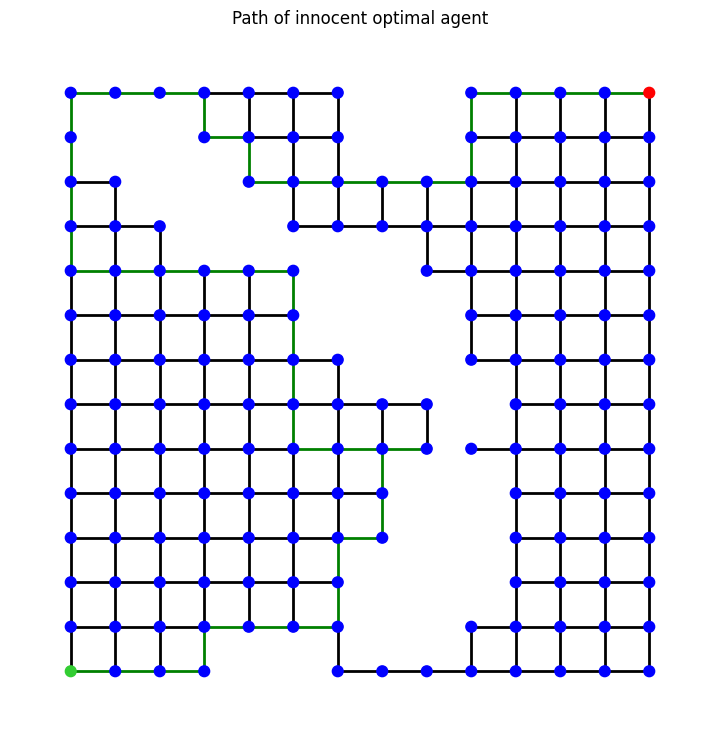

Total path length taken by the agent: 46.00


In [9]:
extended_nodes = [2] if 2 in env_graph else []
non_extended_nodes = [n for n in env_graph.nodes() if n != 2]

path_1_edges = {tuple(sorted((path_1[i], path_1[i+1]))) 
                   for i in range(len(path_1) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(blocked_env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in blocked_env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_1_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=2.0,
    edge_color=edge_color
)

plt.title("Path of innocent optimal agent")
plt.show()

total_path_length = 0.0
for i in range(len(path_1) - 1):
    u = path_1[i]
    v = path_1[i + 1]
    edge_data = env_graph.get_edge_data(u, v)
    if edge_data:
        total_path_length += edge_data.get('distance', 0.0)
print(f"Total path length taken by the agent: {total_path_length:.2f}")

Let's now see how our algorithm tackles the problem

In [10]:
# This is for the agent operating on our definition of the best path

env_graph2 = env_graph.copy()
path2_generator = RepeatedTopK(reward_ratio = 1.0, env_graph=env_graph2, target_graph=target_graph)

path_2 = path2_generator.find_best_path() # Start with the best path
target_nodes = hamiltonian_target_path.copy()  # All target nodes

current_node = path_2[0]
next_target_index = 1 # since 0 is the source
index = 0

while index < len(path_2) - 1:
    next_node = path_2[index + 1]

    # Update the next_target_index 
    if current_node == target_nodes[next_target_index]:
        next_target_index += 1
    
    # Check out all the observable edges
    observable_edges = set(blocked_env_graph.nodes[current_node]["visible_edges"]) # From the actual blocked env graph
    assumed_observable_edges = set(env_graph2.nodes[current_node]["visible_edges"]) # From the agent's world model 
    blocked_edges = assumed_observable_edges - observable_edges
    
    if len(blocked_edges) > 0:
        # Remove blocked edges from agent's world model
        for edge in blocked_edges:
            u, v = edge
            if env_graph2.has_edge(u, v):
                print(f"From {current_node}, observed edge ({u}, {v}) is blocked. Removing from graph.")
                env_graph2.remove_edge(u, v)
        
        # Update the visibility mapping as well
        for node in env_graph2.nodes():
            if "visible_edges" in env_graph2.nodes[node]:
                current_visible = env_graph2.nodes[node]["visible_edges"]
                # Remove any blocked edges from the visible_edges set
                updated_visible = set(current_visible) - blocked_edges
                env_graph2.nodes[node]["visible_edges"] = list(updated_visible)
        
        # Check if any blocked edge is in our current path
        path_edges = [(path_2[i], path_2[i+1]) for i in range(index, len(path_2) - 1)]

        # Create a set that includes both directions of blocked edges
        blocked_edges_both_directions = set()
        for u, v in blocked_edges:
            blocked_edges_both_directions.add((u, v))
            blocked_edges_both_directions.add((v, u))

        if any(edge in blocked_edges_both_directions for edge in path_edges):
            print(f"Blocked edge detected in planned path. Recalculating entire remaining path...")
            
            # Replan through ALL remaining targets
            remaining_targets = target_nodes[next_target_index:]
            new_path = [current_node]
            
            for target in remaining_targets:
                segment = path2_generator.alternate_path_online(new_path[-1], target)
                new_path.extend(segment[1:])  # Append segment excluding the first node (already in new_path)
            
            # Replace the rest of path_1 with the new path
            path_2 = path_2[:index + 1] + new_path[1:]

    # Get the next node from the (possibly updated) path
    next_node = path_2[index + 1]
    
    # Now that we have a traversable path, just go to the next node in path
    print(f"Moving from {current_node} to {next_node}")
    current_node = next_node
    index += 1


TSP Cycle: [(0, 0), (13, 13)]
Processing section from (0, 0) to (13, 13)
Original Hamiltonian Path Reward: -5.714285714285719
Best Path Reward: -4.0000000000000036
Moving from (0, 0) to (1, 0)
Moving from (1, 0) to (2, 0)
Moving from (2, 0) to (3, 0)
Moving from (3, 0) to (3, 1)
Moving from (3, 1) to (3, 2)
From (3, 2), observed edge ((5, 9), (5, 10)) is blocked. Removing from graph.
From (3, 2), observed edge ((8, 5), (9, 5)) is blocked. Removing from graph.
Blocked edge detected in planned path. Recalculating entire remaining path...
Moving from (3, 2) to (3, 1)
Moving from (3, 1) to (4, 1)
Moving from (4, 1) to (5, 1)
Moving from (5, 1) to (6, 1)
Moving from (6, 1) to (6, 0)
Moving from (6, 0) to (7, 0)
Moving from (7, 0) to (8, 0)
Moving from (8, 0) to (9, 0)
Moving from (9, 0) to (10, 0)
Moving from (10, 0) to (10, 1)
Moving from (10, 1) to (10, 2)
Moving from (10, 2) to (10, 3)
Moving from (10, 3) to (10, 4)
Moving from (10, 4) to (10, 5)
Moving from (10, 5) to (10, 6)
Moving fro

Let's plot our agent's path

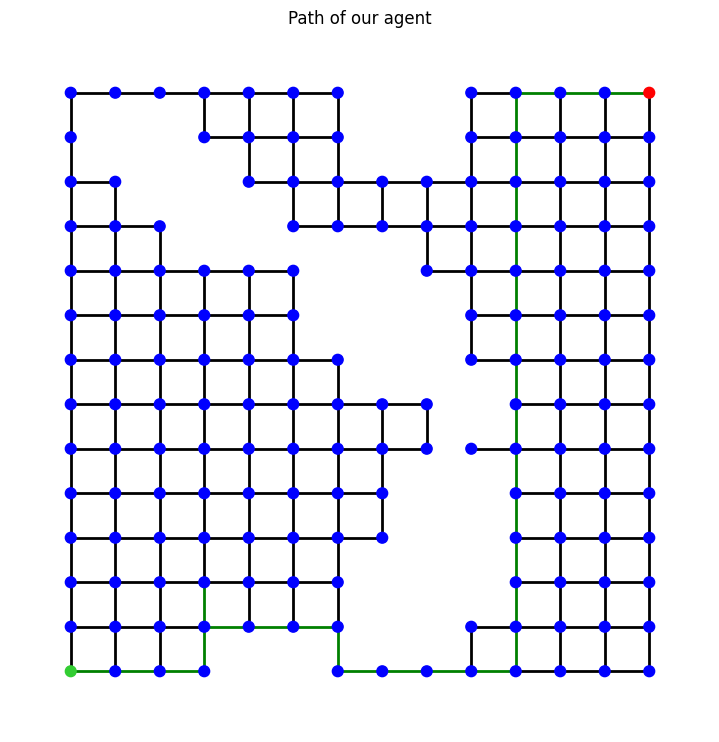

Total path length taken by the agent: 34.00


In [11]:

path_2_edges = {tuple(sorted((path_2[i], path_2[i+1]))) 
                   for i in range(len(path_2) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(blocked_env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in blocked_env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_2_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=2.0,
    edge_color=edge_color
)

plt.title("Path of our agent")
plt.show()

total_path_length = 0.0
for i in range(len(path_2) - 1):
    u = path_2[i]
    v = path_2[i + 1]
    edge_data = blocked_env_graph.get_edge_data(u, v)
    if edge_data:
        total_path_length += edge_data.get('distance', 0.0)
print(f"Total path length taken by the agent: {total_path_length:.2f}")

Let's also compare with a modified VOI agent

In [12]:
# This is for the agent operating on modified VOI

env_graph3 = env_graph.copy()
chokepoints_list = [((1,13), (2,13)),
                    ((5,9), (5,10)),
                    ((8,5), (9,5)),
                    ((7,0), (8,0))]
source_node = (0,0)
target_node = (13,13)
observation_nodes = hill_nodes

path3_generator = VOITrajectoryManager(target_nodes = target_node, 
                                       chokepoints_list=chokepoints_list,
                                       block_prob = 0.05)

path_3 = path3_generator.get_voi_path(env_graph=env_graph3,
                                       current_node=source_node,
                                       target_node=target_node,
                                       obs_node_list=observation_nodes) # Start with the best path
target_nodes = hamiltonian_target_path.copy()  # All target nodes

current_node = path_3[0]
next_target_index = 1 # since 0 is the source
index = 0

while index < len(path_3) - 1:
    next_node = path_3[index + 1]

    # Update the next_target_index 
    if current_node == target_nodes[next_target_index]:
        next_target_index += 1
    
    # Check out all the observable edges
    observable_edges = set(blocked_env_graph.nodes[current_node]["visible_edges"]) # From the actual blocked env graph
    assumed_observable_edges = set(env_graph3.nodes[current_node]["visible_edges"]) # From the agent's world model 
    blocked_edges = assumed_observable_edges - observable_edges
    
    if len(blocked_edges) > 0:
        # Remove blocked edges from agent's world model
        for edge in blocked_edges:
            u, v = edge
            if env_graph3.has_edge(u, v):
                print(f"From {current_node}, observed edge ({u}, {v}) is blocked. Removing from graph.")
                env_graph3.remove_edge(u, v)
        
        # Update the visibility mapping as well
        for node in env_graph3.nodes():
            if "visible_edges" in env_graph3.nodes[node]:
                current_visible = env_graph3.nodes[node]["visible_edges"]
                # Remove any blocked edges from the visible_edges set
                updated_visible = set(current_visible) - blocked_edges
                env_graph3.nodes[node]["visible_edges"] = list(updated_visible)
        
        # Check if any blocked edge is in our current path
        path_edges = [(path_3[i], path_3[i+1]) for i in range(index, len(path_3) - 1)]

        # Create a set that includes both directions of blocked edges
        blocked_edges_both_directions = set()
        for u, v in blocked_edges:
            blocked_edges_both_directions.add((u, v))
            blocked_edges_both_directions.add((v, u))

        if any(edge in blocked_edges_both_directions for edge in path_edges):
            print(f"Blocked edge detected in planned path. Recalculating entire remaining path...")
            
            # Replan through ALL remaining targets
            remaining_targets = target_nodes[next_target_index:]
            new_path = [current_node]
            
            for target in remaining_targets:
                segment = path3_generator.get_voi_path(env_graph=env_graph3, 
                                                       current_node=new_path[-1], 
                                                       target_node=target_node, 
                                                       obs_node_list=observation_nodes)
                new_path.extend(segment[1:])  # Append segment excluding the first node (already in new_path)
            
            # Replace the rest of path_1 with the new path
            path_3 = path_3[:index + 1] + new_path[1:]
    # Get the next node from the (possibly updated) path
    next_node = path_3[index + 1]

    # Now that we have a traversable path, just go to the next node in path
    print(f"Moving from {current_node} to {next_node}")
    current_node = next_node
    index += 1

Moving from (0, 0) to (1, 0)
Moving from (1, 0) to (2, 0)
Moving from (2, 0) to (3, 0)
Moving from (3, 0) to (3, 1)
Moving from (3, 1) to (4, 1)
Moving from (4, 1) to (5, 1)
Moving from (5, 1) to (6, 1)
Moving from (6, 1) to (6, 2)
Moving from (6, 2) to (6, 3)
Moving from (6, 3) to (7, 3)
Moving from (7, 3) to (7, 4)
Moving from (7, 4) to (7, 5)
Moving from (7, 5) to (8, 5)
From (8, 5), observed edge ((8, 5), (9, 5)) is blocked. Removing from graph.
Blocked edge detected in planned path. Recalculating entire remaining path...
Moving from (8, 5) to (7, 5)
Moving from (7, 5) to (6, 5)
Moving from (6, 5) to (5, 5)
Moving from (5, 5) to (5, 6)
Moving from (5, 6) to (5, 7)
Moving from (5, 7) to (5, 8)
Moving from (5, 8) to (5, 9)
From (5, 9), observed edge ((5, 9), (5, 10)) is blocked. Removing from graph.
Blocked edge detected in planned path. Recalculating entire remaining path...
Moving from (5, 9) to (4, 9)
Moving from (4, 9) to (3, 9)
Moving from (3, 9) to (2, 9)
Moving from (2, 9) to 

Plot the VOI agent path

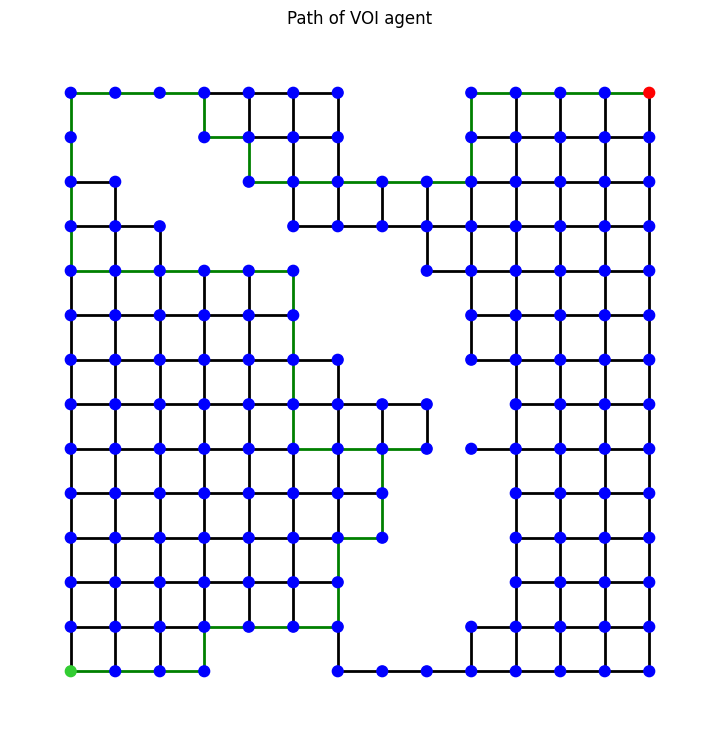

Total path length taken by the agent: 46.00


In [13]:
path_3_edges = {tuple(sorted((path_3[i], path_3[i+1]))) 
                   for i in range(len(path_3) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(blocked_env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in blocked_env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_3_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=2.0,
    edge_color=edge_color
)

plt.title("Path of VOI agent")
plt.show()

total_path_length = 0.0
for i in range(len(path_3) - 1):
    u = path_3[i]
    v = path_3[i + 1]
    edge_data = blocked_env_graph.get_edge_data(u, v)
    if edge_data:
        total_path_length += edge_data.get('distance', 0.0)
print(f"Total path length taken by the agent: {total_path_length:.2f}")

Comparison 4: The ZeroRPP agent $\\$
from the paper Active sensing for motion planning in uncertain environments via mutual information policies

In [ ]:
# This is for the agent operating on modified Zerocost RPP

env_graph4 = env_graph.copy()

# Generate all 16 possible realizations for the 4 chokepoints
realizations = []
chokepoints = [((1,13), (2,13)),
                ((5,9), (5,10)),
                ((8,5), (9,5)),
                ((7,0), (8,0))]
source_node = (0,0)
target_node = (13,13)
edge_block_prob = 0.75

# Calculate all the possible scenrarios (Y in the paper)
for bits in itertools.product([0, 1], repeat=len(chokepoints)):
    # 0 = open, 1 = blocked
    blocked_in_this_world = [chokepoints[i] for i, bit in enumerate(bits) if bit == 1]
    
    # Calculate probability of this specific world occurring
    prob = 1.0
    for bit in bits:
        prob *= edge_block_prob if bit == 1 else (1 - edge_block_prob)
    
    # The set of free edges is all edges in env_graph MINUS the blocked ones
    all_edges = set(env_graph.edges())
    free_edges = all_edges - set(blocked_in_this_world)
    
    realizations.append({
        'prob': prob,
        'edges': free_edges,
        'blocked': set(blocked_in_this_world)
    })

path4_generator = ZeroCostRPP(env_graph=env_graph4,
                              realizations=realizations,
                              start_node=source_node,
                              goal_node=target_node)

policy_tree = path4_generator.plan()

# Y is the set of indices of all realizations [cite: 119, 159]
current_belief_indices = tuple(range(len(realizations)))
current_tree_node = (current_belief_indices, source_node)
current_node = source_node

path_4 = [current_node]  # For plotting purposes
agent4_travel_distance = 0.0

while True:
    node_data = policy_tree.nodes.get(current_tree_node, {})
    
    # 1. Check for Terminal States [cite: 173, 408]
    if node_data.get('type') == 'terminal_no_goal':
        print(f"RPP Determination: Goal is unreachable in this environment.")
        break
    
    if current_node == target_node:
        print(f"Goal Reached! Total distance: {agent4_travel_distance}")
        break

    # 2. Get the next tree action [cite: 170, 250]
    successors = list(policy_tree.successors(current_tree_node))
    if not successors:
        break
    
    # Check if the policy explicitly commands a move to the goal 
    # We look at the action attribute on the edge we are about to traverse
    action_to_take = policy_tree.get_edge_data(current_tree_node, successors[0]).get('action')
    
    if action_to_take == "move_to_g":
        target_env_vertex = target_node
    else:
        # Otherwise, the destination is the vertex associated with the next tree node [cite: 413]
        target_env_vertex = successors[0][1]
    # 3. Traverse the environment vertex-by-vertex [cite: 237, 262]
    # The 'leg' is calculated on the agent's known subgraph [cite: 228, 246]
    leg_path = nx.shortest_path(env_graph4, current_node, target_env_vertex, weight="distance")
    
    # Step through the physical environment
    for next_step in leg_path[1:]:
        # Move the agent and record the step
        distance = env_graph.edges[current_node, next_step]["distance"]
        agent4_travel_distance += distance
        current_node = next_step
        path_4.append(current_node)
        
        # In a real-time scenario, if the robot's sensors detected an 
        # unexpected blockage here (inconsistent with belief), it would 
        # trigger a fallback, but RPP assumes consistent priors[cite: 765, 767].

    # 4. Finish if we reached the goal
    if current_node == target_node:
        print(f"Goal Reached! Total distance: {agent4_travel_distance}")
        break

    # 5. Perform Observation [cite: 152, 154]
    visible_here = env_graph.nodes[current_node].get("visible_edges", [])
    actual_outcome = tuple(sorted(
        [e for e in visible_here if blocked_env_graph.has_edge(*e)],
        key=lambda x: (x[0], x[1])
    ))
    
    # 6. Update Belief State [cite: 201, 253]
    found_next_state = False
    for successor in policy_tree.successors(current_tree_node):
        edge_data = policy_tree.get_edge_data(current_tree_node, successor)
        if edge_data.get('observation_result') == actual_outcome:
            current_tree_node = successor
            found_next_state = True
            break
    
    if not found_next_state:
        print(f"Warning: Inconsistent outcome {actual_outcome} at {current_node}.")
        break

Added observation node: (2, 2)
Added new belief state: ((0,), (2, 2))
Added new belief state: ((1,), (2, 2))
Added new belief state: ((2,), (2, 2))
Added new belief state: ((3,), (2, 2))
Added new belief state: ((4,), (2, 2))
Added new belief state: ((5,), (2, 2))
Added new belief state: ((6,), (2, 2))
Added new belief state: ((7,), (2, 2))
Added new belief state: ((8,), (2, 2))
Added new belief state: ((9,), (2, 2))
Added new belief state: ((10,), (2, 2))
Added new belief state: ((11,), (2, 2))
Added new belief state: ((12,), (2, 2))
Added new belief state: ((13,), (2, 2))
Added new belief state: ((14,), (2, 2))
Added new belief state: ((15,), (2, 2))
Added Goal node, we can get to the goal directly
Added Goal node, we can get to the goal directly
Added Goal node, we can get to the goal directly
Added Goal node, we can get to the goal directly
Added Goal node, we can get to the goal directly
Added Goal node, we can get to the goal directly
Added Goal node, we can get to the goal direc

Let's plot the RPP agent path as well

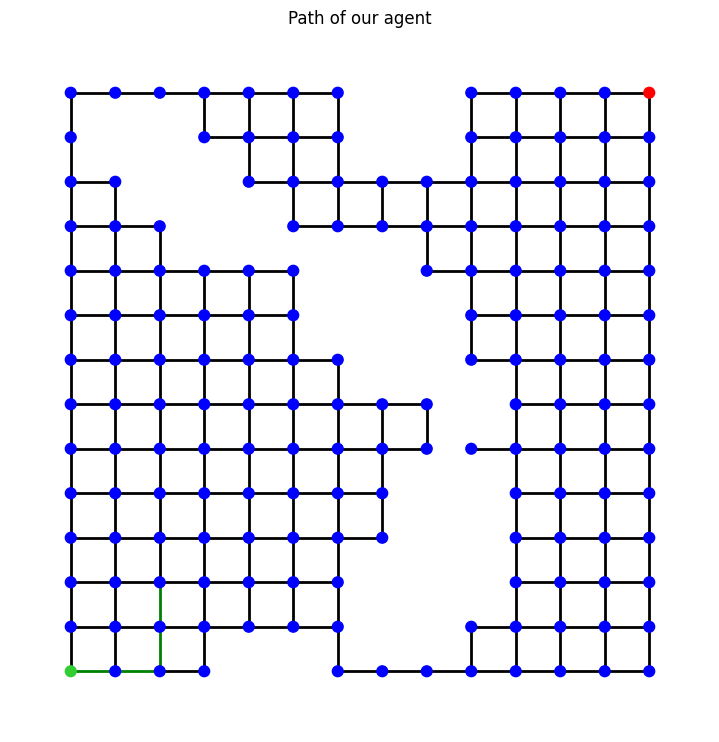

Total path length taken by the agent: 6.00


In [15]:
path_4_edges = {tuple(sorted((path_4[i], path_4[i+1]))) 
                   for i in range(len(path_4) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(blocked_env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in blocked_env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in blocked_env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in path_4_edges:
        # Style for edges on the shortest path but unblocked: green
        edge_color.append('green')
    else:
        # Style for unblocked edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    blocked_env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=2.0,
    edge_color=edge_color
)

plt.title("Path of our agent")
plt.show()

print(f"Total path length taken by the agent: {agent4_travel_distance:.2f}")